### Conducting the randomisation test from FYP - (3) Drift

NOTE: The code below was not written by me but by my supervisor Tin-Yu Hui.

In [1]:
#install.packages("hdf5r")
require(hdf5r)
require(compiler)

Loading required package: hdf5r
Warning message:
"package 'hdf5r' was built under R version 3.6.3"Loading required package: compiler


#### Randomisation F


#### Change only the tab below

In [14]:
# LOAD THE FIRST POPULATION. 2013 HDF5
dat1<-H5File$new('2013_X_int_10.hdf5', 'r')
# LOAD THE SECOND POPULATION. 2015 HDF5
dat2<-H5File$new('2015_X_int_10.hdf5', 'r')

#### Do not change anything below

In [15]:
dat1
dat2

Class: H5File
Filename: C:\Users\isabe\OneDrive - Imperial College London\Final Year Project\2013_X_int_10.hdf5
Access type: H5F_ACC_RDONLY
Listing:
     name    obj_type  dataset.dims dataset.type_class
      POS H5I_DATASET          4677        H5T_INTEGER
 genotype H5I_DATASET 2 x 73 x 4677        H5T_INTEGER

Class: H5File
Filename: C:\Users\isabe\OneDrive - Imperial College London\Final Year Project\2015_X_int_10.hdf5
Access type: H5F_ACC_RDONLY
Listing:
     name    obj_type   dataset.dims dataset.type_class
      POS H5I_DATASET           4677        H5T_INTEGER
 genotype H5I_DATASET 2 x 104 x 4677        H5T_INTEGER

In [16]:
# READ genotype AS R ARRAY, 3D
genotype1<-dat1[['genotype']][,,]
dim(genotype1)
unique(as.numeric(genotype1))

[1]    2   73 4677

[1] 0 1 2 3

In [17]:
# DO THE SAME FOR 2015 HDF5
genotype2<-dat2[['genotype']][,,]
dim(genotype2)
unique(as.numeric(genotype2))

[1]    2  104 4677

[1] 0 1 2 3

In [6]:
# FUNCTION TO RETURN THE FOUR ALLELE COUNTS. PER LOCUS
allele.count<-function(GT)
{
    a1<-GT[1,]
    a2<-GT[2,]
    a<-c(a1, a2)
    return(c(sum(a=='0'), sum(a=='1'), sum(a=='2'), sum(a=='3')))
}

# FUNCTION TO RETURN NUMBER OF ALLELES. PER LOCUS
allelism<-function(allele_count)
{
    return(sum(allele_count>0))
}

# FUNCTION TO CONVERT COUNT TO FREQUENCY, PER LOCUS
allele.frequency<-function(allele_count)
{
    y<-allele_count[1]+allele_count[2]+allele_count[3]+allele_count[4]
    return(allele_count/y)
}

# FUNCTION TO RETURN WHICH LARGEST FREQ? PER LOCUS
# 1 RETURN THE LARGEST, 2 RETURN MAF, ETC
cal.frequency<-function(allele_frequency, which=1)
{
    return(allele_frequency[order(allele_frequency, decreasing=T)[which]])
}

# FUNCTION TO RETURN THE WHICH LARGEST ALLELE (0, 1, 2, 3?) PER LOCUS
# 1 RETURN THE LARGEST
find.allele<-function(allele_count, which=1)
{
    return(order(allele_count, decreasing=T)[which]-1)
}

# FUNCTION TO CONVERT MULTIALLELIC LOCI INTO BIALLELIC (GROUP REMAINING THREE AS ALT)
# RETURN NUMERIC. 0 (REF HOMOZYGOTE), 1 (HETEROZYGOTE), 2, MISSING IS NA
to.biallelic<-function(GT, ref='0')
{
    a1<-GT[1,]
    a2<-GT[2,]
    b1<-1-(a1==ref)
    b2<-1-(a2==ref)
    return(b1+b2)
}

In [18]:
# FIND ALLELE COUNT
allele_count1<-t(apply(genotype1, 3, allele.count))
dim(allele_count1)
allele_count1[1,]

[1] 4677    4

[1]  32 114   0   0

In [19]:
# ALL BIALLELIC?
num_alleles1<-apply(allele_count1, 1, allelism)
unique(num_alleles1)

[1] 2

In [20]:
# TO ALLELE FREQ
af1<-t(apply(allele_count1, 1, allele.frequency))
dim(af1)
af1[1,]

[1] 4677    4

[1] 0.2191781 0.7808219 0.0000000 0.0000000

In [21]:
# FIND MAJOR ALELE FREQ AND ITS SUMMARY
major_f1<-apply(af1, 1, cal.frequency, which=1)
length(major_f1)
summary(major_f1)

[1] 4677

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.5000  0.6986  0.8082  0.7710  0.8699  0.8973 

In [22]:
# FIND THE MAJOR ALLELE 
major_allele1<-apply(allele_count1, 1, find.allele, which=1)
length(major_allele1)

[1] 4677

In [23]:
# CONVERT TO GENOTYPE MATRIX (WITH 0, 1, 2 ONLY, 0 IS THE MAJOR ALLELE)
g1<-matrix(nc=dim(genotype1)[2], nr=dim(genotype1)[3])
g2<-matrix(nc=dim(genotype2)[2], nr=dim(genotype2)[3])
for (i in 1:nrow(g1))
{
    g1[i,]<-to.biallelic(genotype1[,,i], ref=major_allele1[i])
    g2[i,]<-to.biallelic(genotype2[,,i], ref=major_allele1[i])
}
dim(g1)
dim(g2)
unique(as.numeric(g1))
unique(as.numeric(g2))

[1] 4677   73

[1] 4677  104

[1] 1 0 2

[1] 1 0 2

In [24]:
# THE TWO SAMPLE SIZES
s1<-ncol(g1)
s2<-ncol(g2)

# RECALCULATE THE TWO ALLELE FREQ AGAIN
f1<-apply(g1, 1, sum)/(2*s1)
f2<-apply(g2, 1, sum)/(2*s2)

# TEMPORAL Fc
Fa<-mean((f1-f2)^2/(f1*(1-f1)))
Fa

# MINUS SAMPLING ERROR
Fa-0.5/s1-0.5/s2

[1] 0.01188853

[1] 0.0002315206

Fa:
- X_4: 0.0111445581858069
- X_int: 0.0118885280123931 (positive Fa after sampling! But, within the distribution?)
- 3R_int: 0.0112564541599081 (Fa outside of null_Fa distribution and has inf values in null_Fa)
- 3R_4: 0.0112449825807431

In [25]:
# RANDOMISATION
randomise<-function(g1, g2)
{
    s1<-ncol(g1)
    s2<-ncol(g2)
    # SHUFFLE. y IS A VECTOR OF RANDOM NUMBERS
    y<-sample(1:(s1+s2), size=s1)
    rg1<-cbind(g1, g2)[,y]
    rg2<-cbind(g1, g2)[,-y]
    # RECALCULATE ALLELE FREQ, USING THE RANDOMISED POPULATIONS
    rf1<-apply(rg1, 1, .Primitive('sum'))/(2*s1)
    rf2<-apply(rg2, 1, .Primitive('sum'))/(2*s2)
    # RECALCULATE TEMPORAL Fa
    return(mean((rf1-rf2)^2/(rf1*(1-rf1))))
}

In [26]:
# RANDOMISE 1000 TIMES
null_Fa<-rep(NA, 1000)
for (i in 1:length(null_Fa))
{
    null_Fa[i]<-randomise(g1, g2)
}

In [27]:
# PRINT NULL_FA
print(null_Fa[1:10])
max(null_Fa) #Inf value for 3R_int only
min(null_Fa)

 [1] 0.01285148 0.01258651 0.01122100 0.01122314 0.01262367 0.01206594
 [7] 0.01180002 0.01154722 0.01277506 0.01212149


[1] 0.01419831

[1] 0.01038545

In [193]:
# SAVE THE FILES

#write.table(null_Fa, file = "null_Fa_3R_int_10.txt", row.names = FALSE, col.names = FALSE)
#write.table(null_Fa, file = "null_Fa_3R_4_10.txt", row.names = FALSE, col.names = FALSE)
#write.table(null_Fa, file = "null_Fa_X_int_10.txt", row.names = FALSE, col.names = FALSE)
#write.table(null_Fa, file = "null_Fa_X_4_10.txt", row.names = FALSE, col.names = FALSE)

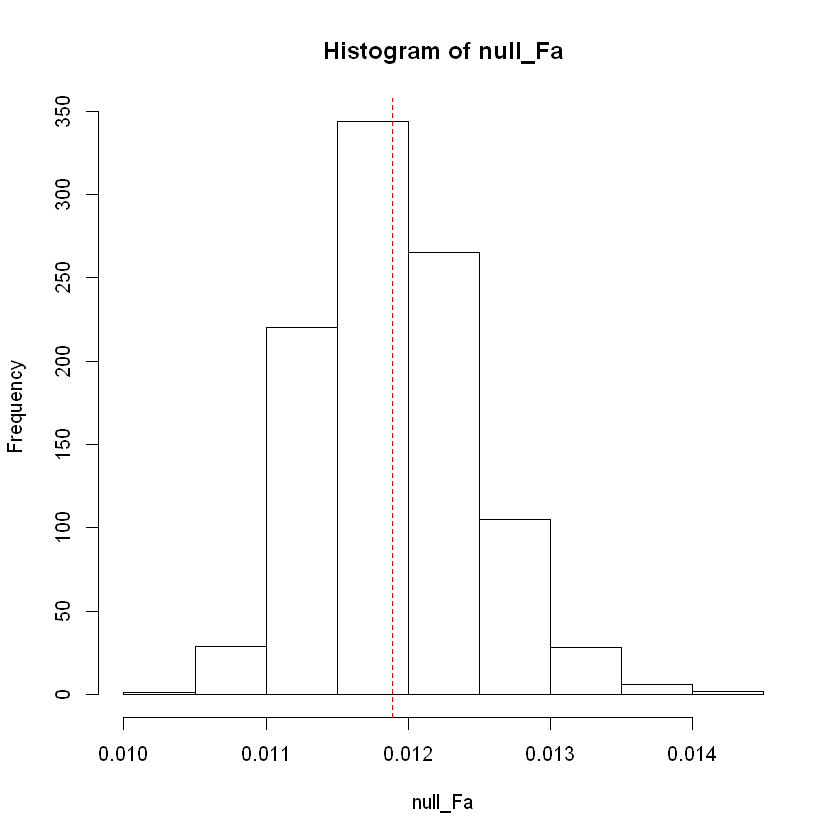

In [28]:
# HISTOGRAM OF NULL
hist(null_Fa)
abline(v=Fa, col='red', lty=2) # Outside the range for 3R_int